<a href="https://colab.research.google.com/github/bforsbe/SK2534/blob/main/Lattice_Folding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar activity: 2D Lattice Protein Folding (Monte Carlo)

This guided notebook introduces concepts related to understand the kinetics of protein folding, starting with simplified simulations exemplyfing state transtitions and energy barriers. It then adapts the classic hydrophobic–polar (HP) lattice protein exercise into a fully self-contained lab.

You will:
- Understand simple concepts regarding folding kinetics.
- Employ Monte Carlo (MC) simulations.
- Use a simple contact score as a proxy for enthalpic stabilization.
- Observe search dynamics with and without a Metropolis acceptance criterion.
- Compare score trajectories and animations.
- Complete conceptual questions and check your work against detailed answers.

All code needed is provided below. You only change a few parameters (e.g., the sequence string or number of steps).



## Imports and Random Seed



In [4]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML

# Deterministic runs unless you change this seed:
rng = np.random.default_rng(42)



# Part 1: Kinetics, Monte Carlo simulations, and the Metropolis criterion

In this section we introduce **stochastic dynamics** using a discrete energy landscape with two local minima.
This provides the foundation for understanding lattice protein folding.

Lets start by saying that a ball could be at 20 differnt positions, moving one step right or left. Each position is a state with some enthalpy. Lets make a plot showing one such case, where the height corresponds to the enthalpy of the state. The ball could be in any of the empty positions show in the plot below


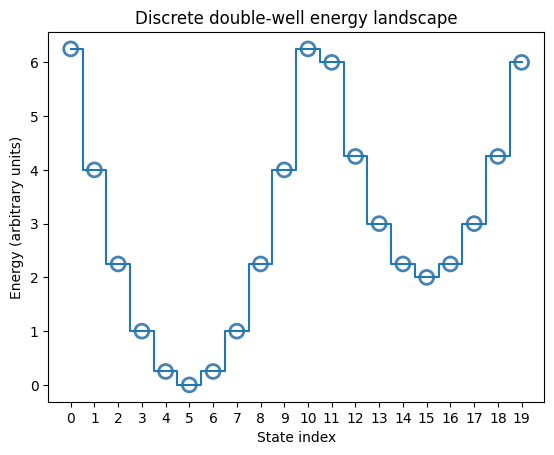

In [5]:
# @title Plot a 1D potential with 20 states
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(1)

# Define discrete states (0..19) with two minima
n_states = 20
E = np.zeros(n_states)

# Make a "double-well" potential: minima at 5 and 15, barrier at 10
for i in range(n_states):
    if i <= 10:
        E[i] = (i-5)**2 / 4
    else:
        E[i] = (i-15)**2 / 4 + 2  # deeper right well

# Plot energy landscape (initial separate plot, can be removed if superimposed is sufficient)
plt.step(range(n_states), E, where='mid')
plt.scatter(np.arange(n_states), E, s=100, facecolors='none', edgecolors='steelblue', linewidths=2) # Modified scatter plot
plt.xlabel("State index")
plt.ylabel("Energy (arbitrary units)")
plt.title("Discrete double-well energy landscape")

import matplotlib.ticker as tck
ax = plt.gca()
ax.xaxis.set_major_locator(tck.MultipleLocator())

plt.show()

If we started in a state with high enthalpy (like state 8), we can guess what would happen:

> *we would immediately fall into successivley lower enthalpy states*

We can mimic this in a step-by-step simulation by
1. Checking which state we are in
2. Proposing a change to another accesible state (in this case any adjacent)
3. Accepting that change if it is favourable (lower in enthalpy).
4. Rejecting the change if it is not favourable (higher in enthalpy).


If we used only steps 1 and 2 repeatedly, we would preform what is known as a **random walk**. Because we are only accepting moves that decrease enthalpy, we are instead performing **optimization** (in this case enthalpy minimization). And becasue the suggested moves are random, it is a flavour of optimization termed **stochastic optimization** or **stochastic descent**.

<details>
  <summary> SIDENOTE regarding optimization (click to expand)</summary>
  <p>
If we were considering a local neighborhood of the current location and chosing to move in the best direction with no randomness, then we would be doing <b>gradient descent</b>. This could also have a random component, in which case it would be <b>stocastic gradient descent</b>.</p>
</details>



---

**Question A1**

Enthalpy minimization is usually not what we want to do to study molecular systems, even though it mimics the tendency of to occupy lower-enthalpy states, like the folding of a protein. What is minimization missing that we need?

<details>
  <summary> Hint (click to expand)</summary>
  <p>
  Think about a few different energy lnadscapes and performing simulations on them. Try to find general ways in which these simulation fail to capture essential dyanmics of the landscape.   
  </p>
</details>

<details>
  <summary> Answer (click to expand)</summary>
  <p>
  1. Systems tend to occupy states with low free energy. This includes entropy. So we need to find a way to simulate with entropy, to find states with low free energy, not just low enthalpy </p><p>
  2. Descent alone will take you to the closest minimum, not necessarily the deepest one</p><p>
  3. It will be impossible to study processes which move between stable states, which have to go temporarily go up in energy.</p>
</details>

---

**Question A2**

How would a systems ever go up in free energy?
<details>
  <summary> Hint (click to expand)</summary>
  <p>
  Think of the kinetic energy of a particle in a gas. How would it gain speed?   
  </p>
</details>

<details>
  <summary> Answer (click to expand)</summary>
  <p>
  A closed system never goes up in energy, but if you divide a system into parts, the balance fluctuates bewteen them in a random fashion. How this energy distributes is described by statistical thermodynamics.   
  </p>
</details>



So we should modify our simulation to that going up is allowed. But if we always allow it then we are balk to a random walk: accept all moves.

Instead, we want a rule that converts the ennthalpy difference to a probability, and accept or reject the move based on that probability.

Imagine you have just two states, with a given difference in enthalpy and no difference in entropy.

$$\Delta H = H_2 - H_1,$$  

A simulation would then always try to move from the current state to the other, state, and see an uphill one way, and a downhill the other. Now what we want is the following:
1. Always accept moves downhill.
2. Given enough time, the total time spent in each state should reflect the Boltzmann distribution:  

$$p(2) \propto e^{-\beta H_2}, \quad p(1) \propto e^{-\beta H_1},\qquad \beta=\frac{1}{k_B T}.$$

The fundamental question is thus:

> What should be the probability of accepting an uphill move?

Let $$\Delta H=H_2-H_1.$$  

and define the probability of moving uphill (depending on change in enthalpy)
as

$$P_{\text{up}}(\Delta H)$$

For condition 2 to hold, the average flow from 1 to 2 must equal the average flow from 2 to 1. That is, the fraction of time we find ourselves in state 1 times the probability we move and accept into 2 must equal the fraction of time we find ourselves in state 2 times the probability we move and accept into 1. This is called **detailed balance**. Using the above definitions, this means that

$$e^{-\beta H_1}\,P_{\text{up}}(\Delta H)=e^{-\beta H_2}\cdot 1$$

Solving for the uphill acceptance probability yields
$$P_{\text{up}}(\Delta H)=e^{-\beta(H_2-H_1)}=e^{-\beta\Delta H}\qquad(\Delta H>0).$$

We can easily make this apply to downhill transitions as well, where the expression would result in more than 100% probability, by simply saying that it is less than or equal to 1:

$$P_{move}(\Delta H)=\min\!\bigl(1,\;e^{-\beta\Delta H}\bigr).$$

This is the **Metropolis criterion**: always accept downhill moves, and accept uphill moves which ensures the system visits states with the desired Boltzmann frequencies.   

Let's see this in action. Lets simulate a stochastic random walk under the metropolis criterion for the energy we just plotted before.

We will also compare the expected state polulations and transition probabilities to those observed during the random walk.

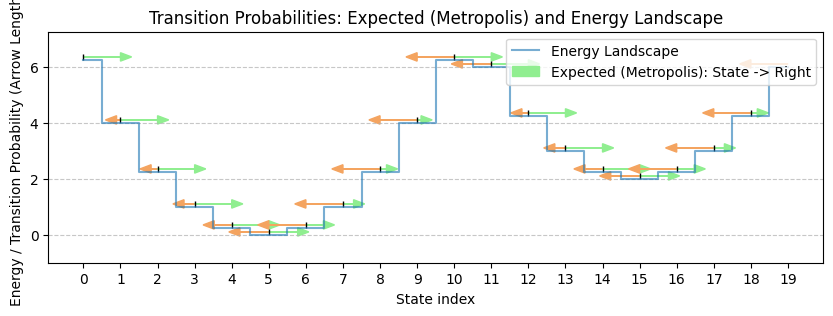

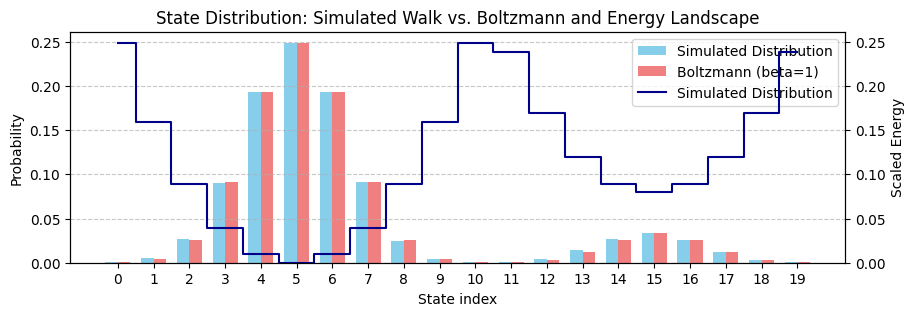

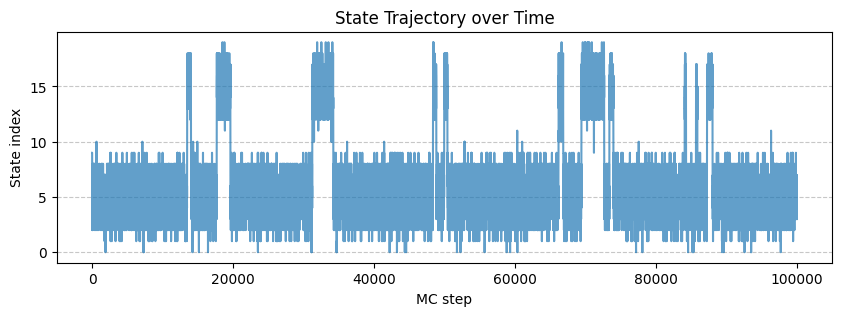

In [6]:
# @title


# Use Metropolis criterion (default to True)
use_metropolis = True #@param {type:"boolean"}
steps = 100000 #@param {type:"integer"}
f_height = 3

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(1)

# Define discrete states (0..19) with two minima
n_states = 20
E = np.zeros(n_states)

# Make a "double-well" potential: minima at 5 and 15, barrier at 10
for i in range(n_states):
    if i <= 10:
        E[i] = (i-5)**2 / 4
    else:
        E[i] = (i-15)**2 / 4 + 2  # deeper right well


# Simulate a random walk on the 1D energy landscape with Metropolis criterion
n_steps_rw = steps  # Number of steps for the random walk
current_state = rng.integers(n_states) # Start at a random state
state_history_rw = [current_state]


beta = 1.0 # Assuming beta=1 for Boltzmann factor

for _ in range(n_steps_rw):
    # Propose a random move: -1 (left) or +1 (right)
    move = rng.choice([-1, 1])
    next_state = current_state + move

    # Check if the proposed state is within bounds (0 to n_states-1)
    if 0 <= next_state < n_states:
        # Calculate energy change
        delta_E = E[next_state] - E[current_state]

        # Metropolis acceptance criterion
        if use_metropolis:
            if delta_E <= 0: # Accept downhill or equal moves
                current_state = next_state
            else: # Accept uphill moves with probability exp(-beta * delta_E)
                acceptance_prob = np.exp(-beta * delta_E)
                if rng.random() < acceptance_prob:
                    current_state = next_state
        else:
            # Pure random walk: accept all valid moves
            current_state = next_state

    state_history_rw.append(current_state)


# Analyze state distribution
state_counts_rw = np.bincount(state_history_rw, minlength=n_states)
state_distribution_rw = state_counts_rw / np.sum(state_counts_rw)

# Calculate Boltzmann probabilities (assuming beta=1)
boltzmann_probs = np.exp(-beta * E)
boltzmann_distribution = boltzmann_probs / np.sum(boltzmann_probs)


# Analyze Transition Probabilities
# Initialize transition counts: counts[from_state][move_direction]
# move_direction: 0 for left (-1), 1 for right (+1)
transition_counts_rw = np.zeros((n_states, 2))

for i in range(len(state_history_rw) - 1):
    current = state_history_rw[i]
    next = state_history_rw[i+1]
    if next == current - 1: # Moved left
        transition_counts_rw[current, 0] += 1
    elif next == current + 1: # Moved right
        transition_counts_rw[current, 1] += 1
    # If next == current, it was a rejected move, which doesn't count as a transition in this view


# Calculate observed transition probabilities
# Avoid division by zero if a state was never visited or had no successful transitions
observed_transition_probs_rw = np.zeros((n_states, 2))
for i in range(n_states):
    # Count attempts to move left/right from this state (successful or rejected)
    attempted_moves = 0
    successful_moves = np.sum(transition_counts_rw[i, :])

    # To calculate observed transition probability, we need to know how many times we were *at* this state
    times_at_state = state_counts_rw[i]

    if times_at_state > 0:
         # Assuming at each step, a move (left or right) is proposed if possible
         # If at state i (not edge), ~0.5 attempts left, ~0.5 attempts right
         # If at edge state, ~1 attempt towards center
         # A more precise way is to count how many times we were *at* state i and proposed a move
         # For simplicity here, let's calculate probability of *successful* transition given we are at the state
         # This is (# successful moves from i) / (# times at i)

         if times_at_state > 0: # Avoid division by zero
             observed_transition_probs_rw[i, 0] = transition_counts_rw[i, 0] / times_at_state # Prob of *successful* move to left neighbor
             observed_transition_probs_rw[i, 1] = transition_counts_rw[i, 1] / times_at_state # Prob of *successful* move to right neighbor


# Calculate Expected transition probabilities with Metropolis
expected_transition_probs_metropolis = np.zeros((n_states, 2))
for i in range(n_states):
    # Probability of proposing a move (assuming uniform proposal): 0.5 for left, 0.5 for right if neighbors exist
    prob_propose_left = 0.5 if i > 0 else 0.0
    prob_propose_right = 0.5 if i < n_states - 1 else 0.0

    # Probability of accepting a move
    # Acceptance(i -> i-1) = min(1, exp(-beta * (E[i-1] - E[i]))) if i > 0
    # Acceptance(i -> i+1) = min(1, exp(-beta * (E[i+1] - E[i]))) if i < n_states - 1

    if i > 0:
        delta_E_left = E[i-1] - E[i]
        acceptance_left = min(1.0, np.exp(-beta * delta_E_left))
        expected_transition_probs_metropolis[i, 0] = prob_propose_left * acceptance_left # Expected prob of successful transition to left

    if i < n_states - 1:
        delta_E_right = E[i+1] - E[i]
        acceptance_right = min(1.0, np.exp(-beta * delta_E_right))
        expected_transition_probs_metropolis[i, 1] = prob_propose_right * acceptance_right # Expected prob of successful transition to right


# Plot Transition Probabilities with arrows and superimposed energy landscape
fig2, ax2 = plt.subplots(figsize=(10, f_height))

# Plot the energy landscape on the left y-axis
ax2.step(np.arange(n_states), E, where='mid', linestyle='-', label='Energy Landscape', alpha=0.6) # Use step plot

# Plot Expected transition probability arrows at the height of the energy landscape
arrow_scale = 2 # Adjust arrow length
arrow_head_width = 0.3 # Make arrows narrower (absolute units)
arrow_head_length = 0.3 # Make arrows narrower (absolute units)

for i in range(n_states):
    arrow_y = E[i]+0.1 # Plot arrow at the height of the raw energy landscape

    # Expected left
    if expected_transition_probs_metropolis[i, 0] > 0:
         ax2.arrow(i, arrow_y, -expected_transition_probs_metropolis[i, 0] * arrow_scale, 0,
                  head_width=arrow_head_width, head_length=arrow_head_length, fc='sandybrown', ec='sandybrown', label='Expected (Metropolis): State -> Left' if i == 0 else "")
    # Expected right
    if expected_transition_probs_metropolis[i, 1] > 0:
         ax2.arrow(i, arrow_y, expected_transition_probs_metropolis[i, 1] * arrow_scale, 0,
                  head_width=arrow_head_width, head_length=arrow_head_length, fc='lightgreen', ec='lightgreen', label='Expected (Metropolis): State -> Right' if i == 0 else "")

    if expected_transition_probs_metropolis[i, 1] > 0:
         ax2.arrow(i, E[i], 0, 0.2,
                  head_width=0, head_length=0, fc='black', ec='black')


ax2.set_xlabel("State index")
ax2.set_ylabel("Energy / Transition Probability (Arrow Length)") # Combined label
ax2.set_title("Transition Probabilities: Expected (Metropolis) and Energy Landscape") # Updated title
ax2.set_xticks(np.arange(n_states))
ax2.grid(axis='y', linestyle='--', alpha=0.7)
# Adjust y-limits to accommodate both energy and arrows
ax2.set_ylim(-1 + np.min(E), 1+max(np.max(E), arrow_scale))

# Combine legends
ax2.legend(loc='upper right')


plt.show()

# Plot State Distribution
fig1, ax1 = plt.subplots(figsize=(10, f_height))
bar_width = 0.35
ax1.bar(np.arange(n_states) - bar_width/2, state_distribution_rw, bar_width, label='Simulated Distribution', color='skyblue')
ax1.bar(np.arange(n_states) + bar_width/2, boltzmann_distribution, bar_width, label='Boltzmann (beta=1)', color='lightcoral')
ax1.set_xlabel("State index")
ax1.set_ylabel("Probability")
ax1.set_title("State Distribution: Simulated Walk vs. Boltzmann and Energy Landscape")
ax1.set_xticks(np.arange(n_states))
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Create a secondary y-axis for the energy landscape
ax1_twinx = ax1.twinx()
# Scale the energy data to fit the probability range
energy_scaled = (E - np.min(E)) / (np.max(E) - np.min(E)) * np.max(state_distribution_rw) # Simple scaling
ax1_twinx.step(np.arange(n_states), energy_scaled, where='mid', color='darkblue', linestyle='-', label='Scaled Energy Landscape') # Use step plot
ax1_twinx.set_ylabel("Scaled Energy")
ax1_twinx.set_ylim(ax1.get_ylim()) # Match the y-axis limits

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines_twinx, labels_twinx = ax1_twinx.get_legend_handles_labels()
ax1.legend(lines1 + lines_twinx, labels1 + labels1 + labels_twinx, loc='upper right')

plt.show()

# Plot State number as a function of time
plt.figure(figsize=(10, f_height))
plt.plot(state_history_rw, '-', alpha=0.7)
plt.xlabel("MC step")
plt.ylabel("State index")
plt.title("State Trajectory over Time")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


if 'use_metropolis' in locals():
    del use_metropolis

### Run the walk for 10'000 steps. Look at the plot showing the states and distributions, and try to answer the following questions.

**Question B1**

Which states seem to have the largest difference to theory?  

<details>
  <summary> Hint (click to expand)</summary>
  <p>
  Think about how frequently different states are visited during the simulation.
  </p>
</details>

<details>
  <summary> Answer (click to expand)</summary>
  <p>
  Those higher in energy, because they are visited (sampled) less frequently.
  </p>
</details>

---

**Question B2**

How would you define a macrostate in terms of the energy diagram shown?  

<details>
  <summary> Hint (click to expand)</summary>
  <p>
  This has nothing to do with the simulation, but with how we think about the essentials of the energy landscape.
  </p>
</details>

<details>
  <summary> Answer (click to expand)</summary>
  <p>
  By grouping multiple microstates together into a single collective state (macrostate).
  </p>
</details>

---

**Question  B3**

Could you define meaningful macrostates to simplify the energy diagram and still capture the essence of it?  

<details>
  <summary> Hint (click to expand)</summary>
  <p>
  The "essence" here is transitions between two (meta)stable states.
  </p>
</details>

<details>
  <summary> Answer (click to expand)</summary>
  <p>
  Yes — a simple 3-state model: one stable state (left well), one transition state (barrier), and another stable state (right well).
  </p>
</details>

---

**Question B4**

Looking at the state index (random walk) over time in the last plot, how would you use this to estimate a rate?  

<details>
  <summary> Answer (click to expand)</summary>
  <p>
  By counting transitions between macrostates as a function of time. The number of observed transitions divided by the total simulation time gives an estimate of the transition rate.
  </p>
</details>

---

**Question  B5**

If we added a couple of states in the right well that have the same energy as its minimum, a simulation would spend more time there, bouncing around for longer before transitioning to the left well. Considering our macrostates "left well" and "right well," this displaces the population towards one. So we must have changed its free energy. How?  

<details>
  <summary> Hint (click to expand)</summary>
  <p>
  There are more ways to be in the right well.
  </p>
</details>

<details>
  <summary> Answer (click to expand)</summary>
  <p>
  Its entropy has increased, making the right well more favorable in terms of free energy.
  </p>
</details>


# Part 2: Protein folding on a lattice

Monte carlo simulations can be more generally applied of course. We can say that the configuration of a chain of amino acids is a state, and define a score that we can calculate based on that configuration. The number of states is now alot more than 20.

If we *massivel* restrict the proble to consider chains on a grid, then we are talking about what mathematicians call a **self-avoiding walk**. For a self-avoding walk in 2D, the number of states is roughly

$$2.638^n$$

where n is the number of links in the chain (steps in the walk). For n=10, this is roughly 16'000.

> This makes it somewhat tractable to simulate, but hard enough that we can't know the right answer by guessing.

So let's define what we need to simulate it, and fold some proteins.  


## Background and Model Assumptions (rules of the game / simulation)

1. **Hydrophobic/Polar (HP) lattice model.** Each residue (amino acid) is either hydrophobic (H) or polar (P). The chain lives on a 2D square lattice with unit bond length.
2. **Self-avoiding walk (SAW).** The chain may not overlap itself; each lattice site can host at most one residue.
3. **Energy proxy (score).** We use an integer **score** in place of a physically dimensioned energy based on e.g. Lennard-Jones or so. The score rewards H–H contacts that are adjacent on the lattice. Contacts between residues adjacent along the backbone do not contribute.
4. **Monte Carlo moves.** We apply local moves (end moves, corner flips) via a simple perturbation scheme that preserves bond length and avoids self-intersections. A single monte-carlo move can be more than one random change.
5. **Metropolis acceptance.** By default we use a Metropolis-like rule with an implicit temperature scaling: uphill moves are probabilistically accepted with P ≈ exp(−|Δscore|). Turning Metropolis off is equivalent to exploring at very high “temperature.”
6. **Goals.** This model is too crude to predict real structures, but it is excellent for learning how sequence patterns, contact preferences, and search dynamics interact to create compact, stabilized conformations on a rugged energy landscape.



## Define the Sequence and Index Sets

Lets make a "protein" made from either hydrophobic or polar (hydrophilic) amino acids. This will simply be a string of letters, where "H" means hydrofobix and "W" means polar.


Sequence length: 19
H indices: [0, 2, 4, 5, 7, 12, 13, 14, 15, 16, 17, 18]
P indices: [1, 3, 6, 8, 9, 10, 11]


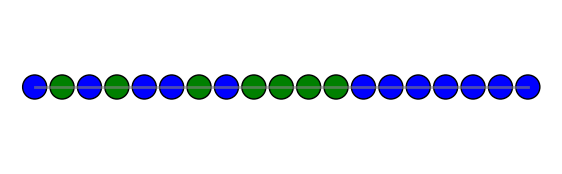

In [7]:

# Student parameter: sequence string with 'H' and 'W' only.
sequence = "HPHPHHPHPPPPHHHHHHH" #@param{type:"string"}
NrResidues = len(sequence)

# Hydrophobic and polar index lists (used in scoring and visualization)
indexHPL = [i for i,b in enumerate(sequence) if b == "P"]
indexHPH = [i for i,b in enumerate(sequence) if b == "H"]

# Colors for visualization (H=blue, W=green)
colors = ['blue' if s == 'H' else 'green' for s in sequence]

print(f"Sequence length: {NrResidues}")
print(f"H indices: {indexHPH}")
print(f"P indices: {indexHPL}")

fig, ax = plt.subplots(figsize=(7, 2))

# Remove axes, ticks, and spines
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

# Or hide the whole axis box
ax.axis('off')

ax.scatter(np.arange(NrResidues), np.arange(NrResidues)*0, s=300, c=colors, edgecolors='black') # Increased marker size
ax.plot(np.arange(NrResidues), np.arange(NrResidues)*0, lw=2, alpha=0.6, color='gray') # Increased line thickness
plt.show()



## Warmup: Scoring by Hand

To make sure you understand the scoring used, you will now score a few configurations by hand.

- Count H–H contacts at Manhattan distance 1 that are **not** along the backbone.
- Multiply the number of such contacts by `score_weight` (take `score_weight = 2`).

Calculate the score of of each of the below configurations by hand.

<div>
<img src="https://github.com/bforsbe/SK2534/raw/main/scorethem.png" width="500"/>
</div>

<details>
  <summary> Answer (click to expand)</summary>
  <div>
<img src="https://github.com/bforsbe/SK2534/raw/main/scoredthem.png" width="500"/>
</div>
</details>




## Chain Initialization and Local Moves

We represent the chain as an array of 2D integer coordinates (x, y) on a square lattice. So we need a way of making and change the chain.

- **Initialization**: self-avoiding random walk builder (with fallback if a SAW cannot be found within a cap on attempts).
- **Moves**: end moves and corner flips via a compact perturbation rule that keeps bonds at unit length and rejects self-intersections.


In [8]:
# @title RUNME: Define how to build and update the chain
def randomWalkN(dimension, residues, rng):
    base = np.zeros(dimension)
    positions = np.tile(base, (residues, 1))
    attempts = 0
    limit = 100
    while (len(set(map(tuple, positions))) < residues) and (attempts < limit):
        for i in range(residues - 1):
            change = rng.random(dimension) - 0.5
            change = np.sign(change) * (np.abs(change) == np.max(np.abs(change)))
            positions[i+1] = positions[i] + change
        attempts += 1
    if attempts == limit:
        # fallback: simple alternating walk
        dualbase = np.tile([[0., 1.], [1., 0.]], (residues, 1))
        positions = np.cumsum(dualbase, axis=0)[:residues]
    return positions

def perturbChain(chain, pos, rng):
    newchain = np.array(np.copy(chain))
    if (pos == 0) or (pos == len(chain) - 1):
        # End move
        ref = newchain[pos + 1] if pos == 0 else newchain[pos - 1]
        suggests = np.tile(ref, (4, 1)) + np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
        choice = rng.integers(4)
        newchain[pos] = suggests[choice]
    else:
        # Corner flip (or do-nothing if straight)
        df = newchain[pos + 1] - newchain[pos]
        ds = newchain[pos - 1] - newchain[pos]
        dBis = df + ds
        # If straight, cannot flip; reject
        if np.abs(dBis[0]) == 0 and np.abs(dBis[1]) == 0:
            return chain
        newchain[pos] += np.sign(dBis)
    # Reject self-intersections
    if len(set(map(tuple, newchain))) < len(newchain):
        return chain
    return newchain

def MHdistance(P1, P2):
    # Manhattan distance
    return np.sum(np.abs(P2 - P1))

def center_chain(chain):
    """Centers the chain around the origin (0,0)."""
    com = np.mean(chain, axis=0)
    return chain - np.round(com) # Translate by the rounded center of mass


## Scoring Function (Contact Score)

We award `score_weight` points for each **non-consecutive H–H contact**. Backbone neighbors do not count.

This is what you did by hand, but its a bit easier to have the computer do it.


In [114]:
# @title RUNME: Define the chain score function

def lower_diag_filter(n, omit=1):
    """
    Create a filter for unique non-adjacent matrix pairs

    n      : number of grid points along x and y
    omit   : how many adjacent to skip
    """
    x = np.arange(0, n, 1)
    y = n - np.arange(0, n, 1)
    X, Y = np.meshgrid(x, y, indexing='xy')   # X[i,j]=x_j, Y[i,j]=y_i
    D = X + Y                                  # Manhattan distance to (0,0) in first quadrant
    return D < n-omit

def select_indices_from_matrix(A,L):
    I, J = np.meshgrid(L, L, indexing="ij")
    # Fancy index into arr
    selected = A[I, J]   # shape (len(L), len(L), 2)

    return selected

def scoreChain(chain, indexHPH, score_weight=2.0):
    """
    Calculates the score of a protein chain configuration using an all-vs-all distance matrix.

    Args:
        chain (np.ndarray): A numpy array of shape (NrResidues, 2) representing the chain's coordinates.
        indexHPH (list): A list of indices corresponding to hydrophobic residues in the sequence.
        score_weight (float): The score awarded for each non-consecutive H-H contact.

    Returns:
        float: The calculated score of the chain.
    """
    NrResidues = len(chain)
    Tscore = 0.0

    # Calculate all-vs-all Manhattan distances
    diff   = chain[:, np.newaxis, :] - chain[np.newaxis, :, :]
    dist_manhattan = np.sum(np.abs(diff), axis=-1)

    filter = lower_diag_filter(NrResidues, omit=1)
    dist_manhattan_H = select_indices_from_matrix((dist_manhattan * filter).astype(np.int8),np.array(indexHPH))

    # Find contacts with Manhattan distance 1
    contacts = np.where(dist_manhattan == 1)
    contacts_H = dist_manhattan_H == 1

    # Filter for non-consecutive H-H contacts below the diagonal
    for i, j in zip(*contacts):
        # Only consider pairs where i < j to avoid double counting and self-contacts
        if i < j:
            # Check if both residues are hydrophobic
            if i in indexHPH and j in indexHPH:
                # Check if they are not consecutive along the backbone
                if abs(i - j) > 1:
                    Tscore += score_weight

    fastscore = np.sum(contacts_H) * score_weight

    if Tscore != fastscore:
        print("ERROR")
        print(Tscore,fastscore)
        #print(dist_manhattan_H)

    return Tscore

In [82]:
import numpy as np

def select_indices_from_matrix(A,L):
    I, J = np.meshgrid(L, L, indexing="ij")
    # Fancy index into arr
    selected = A[I, J]   # shape (len(L), len(L), 2)

    return selected
# Example data
n = 6
arr = np.arange(n*n*2).reshape(n, n, 2)   # shape (n,n,2)

L = [0, 1, 4]   # indices you want

selected = select_indices_from_matrix(arr,L)
print(selected.shape)

print(arr[:,:,0])
print(selected.shape)  # (3,3,2)
print(selected[:,:,0])

(3, 3, 2)
[[ 0  2  4  6  8 10]
 [12 14 16 18 20 22]
 [24 26 28 30 32 34]
 [36 38 40 42 44 46]
 [48 50 52 54 56 58]
 [60 62 64 66 68 70]]
(3, 3, 2)
[[ 0  2  8]
 [12 14 20]
 [48 50 56]]



## Monte Carlo Engine
You know what a monte carlo simulation is now. Our chain simulation will have a few crucial parameters

Parameters:
- `steps`: number of MC steps to run
- `perts`: local perturbations per step, i.e. random chain changes per step
- `score_weight`: H–H contact reward
- `use_metropolis`: if True, accept with Metropolis-like criterion; otherwise, always accept proposed state, **even if it is uphill**


In [89]:
# @title RUNME: Define the simulation function (engine)
def run_simulation(sequence, steps=5000, perts=10, score_weight=2.0, use_metropolis=True, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    NrResidues = len(sequence)
    indexHPH = [i for i,b in enumerate(sequence) if b == "H"]
    chain = randomWalkN(2, NrResidues, rng)
    chain = center_chain(chain) # Center the initial chain
    score = scoreChain(chain, indexHPH, score_weight)
    bestChain = np.copy(chain)
    bestScore = score

    best_chains_history = [bestChain.copy()]
    best_scores_history = [bestScore]
    best_steps_history = [0]

    scores = [score]
    chains = [chain.copy()]

    for step in range(steps):
        Tchain = np.copy(chain)
        for _ in range(perts):
            res = rng.integers(NrResidues)
            Tchain = perturbChain(Tchain, res, rng)
        Tchain = center_chain(Tchain) # Center the proposed chain
        Tscore = scoreChain(Tchain, indexHPH, score_weight)

        if use_metropolis:
            if Tscore > score:
                chain = Tchain
                score = Tscore
            else:
                if rng.random() < np.exp(-abs(Tscore - score)):
                    chain = Tchain
                    score = Tscore
        else:
            chain = Tchain
            score = Tscore

        if score > bestScore:
            bestScore = score
            bestChain = chain.copy()
            best_chains_history.append(bestChain.copy())
            best_scores_history.append(bestScore)
            best_steps_history.append(step)

        scores.append(score)
        chains.append(chain.copy())

    if best_steps_history[-1] != steps - 1 and steps > 0:
         best_chains_history.append(bestChain.copy())
         best_scores_history.append(bestScore)
         best_steps_history.append(steps - 1)


    return chains, scores, bestChain, bestScore, best_chains_history, best_scores_history, best_steps_history


## Run a Folding Simulation

You can change the parameters below to explore behavior.


In [115]:
# @title RUNME: Protein Lattice Simulation

# Student parameter: sequence string with 'H' and 'W' only.
sequence = "HHHPPPPHHPPHHHHHHHPP" #@param{type:"string"}

steps = 5000 #@param{type:"integer"}
perts = 50 #@param{type:"integer"}
score_weight = 3.0 #@param{type:"number"}
use_metropolis = True #@param{type:"boolean"}
bestScore = 0

NrResidues = len(sequence)
indexHPL = [i for i,b in enumerate(sequence) if b == "P"]
indexHPH = [i for i,b in enumerate(sequence) if b == "H"]
colors = ['blue' if s == 'H' else 'green' for s in sequence]

rng = np.random.default_rng(42) # Use the original seed for reproducibility

chains, scores, bestChain, bestScore, best_chains_history, best_scores_history, best_steps_history = run_simulation(
    sequence,
    steps=steps,
    perts=perts,
    score_weight=score_weight,
    use_metropolis=use_metropolis,
    rng=rng
)

## Animate the simulation

PLotting in python is time-consuming, so you can choose to only show every few steps.

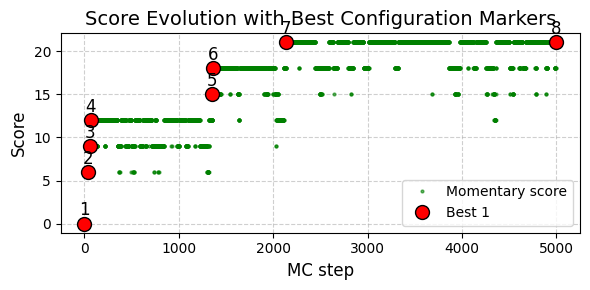

In [116]:
# @title RUNME: Visualize

frame_step = 100 #@param{type:"integer"}
chains_sel = chains[::frame_step]
scores_sel = scores[::frame_step]

grid_size = math.ceil(math.sqrt(len(best_chains_history)))
grid_spacing = len(sequence)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7)) # Increased figure size

pad = max(6, int(NrResidues/2))

ax1.set_xlim(-pad, pad)
ax1.set_ylim(-pad, pad)
ax2.set_xlim(-grid_spacing*grid_size//2, grid_spacing*grid_size//2)
ax2.set_ylim(-grid_spacing*grid_size//2, grid_spacing*grid_size//2)
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')
ax2.set_title("Best so far configurations", fontsize=14) # Increased title font size
ax2.axis('off')

scat1 = ax1.scatter(chains_sel[0][:,0], chains_sel[0][:,1], s=300, c=colors, edgecolors='black') # Increased marker size
line1, = ax1.plot(chains_sel[0][:,0], chains_sel[0][:,1], lw=2, alpha=0.6, color='gray') # Increased line thickness

best_chain_plots_scat = [] # List to store scatter plots for best chains
best_chain_plots_line = [] # List to store line plots for best chains
best_chain_labels = [] # To store text labels for removal

plotted_best_indices = set() # To keep track of which best chains have been plotted

def update(frame):
    chain = chains_sel[frame]
    scat1.set_offsets(chain)
    line1.set_data(chain[:,0], chain[:,1])
    ax1.set_title(f"Frame {frame+1}/{len(chains_sel)} | Current score = {scores[min(frame*frame_step, len(scores)-1)]:.1f} | Best = {bestScore:.1f}", fontsize=12) # Increased title font size

    current_step_in_full_sim = frame * frame_step # Map animation frame to full simulation step

    # Check for new best configurations to plot
    for idx, step in enumerate(best_steps_history):
        if step <= current_step_in_full_sim and idx not in plotted_best_indices:
            best_chain = center_chain(best_chains_history[idx])

            n_best = len(plotted_best_indices)
            # Calculate grid position
            row = n_best // grid_size
            col = n_best % grid_size

            # Calculate translation offset
            # Approximate size of chain bounding box
            chain_width = np.max(best_chain[:, 0]) - np.min(best_chain[:, 0])
            chain_height = np.max(best_chain[:, 1]) - np.min(best_chain[:, 1])
            max_dim = max(chain_width, chain_height)
            spacing = grid_spacing #max(max_dim * 1.5, 2 * math.sqrt(NrResidues)) # Adjust spacing based on chain size

            offset_x = col * spacing - (grid_size - 1) * spacing / 2
            offset_y = -row * spacing + (grid_size - 1) * spacing / 2 # Negative for rows going down

            translated_best_chain = best_chain + np.array([offset_x, offset_y])

            # Plot the new best chain on the second subplot
            scat2 = ax2.scatter(translated_best_chain[:,0], translated_best_chain[:,1], s=50, c=colors, edgecolors='black') # Increased marker size
            line2, = ax2.plot(translated_best_chain[:,0], translated_best_chain[:,1], lw=2, alpha=0.6, color='gray') # Increased line thickness
            best_chain_plots_scat.append(scat2)
            best_chain_plots_line.append(line2)

            x_lbl=np.min(translated_best_chain[:,0])
            y_lbl=np.max(translated_best_chain[:,1])
            # Add a label for the best chain
            label = ax2.text(x_lbl-3, y_lbl+3, str(idx + 1), fontsize=14, ha='center') # Increased font size and added weight
            best_chain_labels.append(label)

            plotted_best_indices.add(idx)




    return (scat1, line1) + tuple(best_chain_plots_scat) + tuple(best_chain_plots_line) + tuple(best_chain_labels)


ani = anim.FuncAnimation(fig, update, frames=len(chains_sel), interval=200, blit=False) # Blit set to False due to dynamic elements
plt.close(fig)
display(HTML(ani.to_jshtml()))

# Score plot
plt.figure(figsize=(6, 3)) # Increased figure size
plt.plot(scores, '.g', ms=4, label='Momentary score', alpha=0.6) # Increased marker size and added transparency

# Add markers and labels for best configurations with improved positioning
for i, step in enumerate(best_steps_history):
    plt.plot(step, best_scores_history[i], 'ro', ms=10, label=f'Best {i+1}' if i == 0 else "", markeredgewidth=1, markeredgecolor='black') # Increased marker size, added label for legend, and outline
    # Adjust text position to avoid overlap
    plt.text(step, best_scores_history[i] + 0.5, str(i + 1), fontsize=12, ha='center', va='bottom')


plt.xlabel("MC step", fontsize=12) # Increased label font size
plt.ylabel("Score", fontsize=12) # Increased label font size
plt.title("Score Evolution with Best Configuration Markers", fontsize=14) # Increased title font size
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6) # Added grid for better readability
plt.tight_layout()
plt.show()


## Part 8 — Sequence Design Challenge

Task: Design a 20–30 residue sequence that folds into a compact state with a high score. Try obvious patterns (e.g., blocks of H’s) and compare to alternating sequences.

Suggestions to try (copy into the sequence cell and rerun):
- Compact-promoting: `HHHHHWWWWHHHHHWWWWHHHH`
- Alternating: `HWHWHWHWHWHWHWHWHWHW`
- Mixed blocks: `HHHWHHWWWHHHWHHWWWHHH`

Explain what you observe in terms of the number and geometry of non-consecutive H–H contacts formed.



<details>
<summary>Answer (detailed)</summary>

- **Blocky sequences** with contiguous H segments make it easier to form compact hydrophobic cores, increasing the number of non-consecutive H–H contacts and thus the score.  
- **Perfectly alternating sequences** tend to frustrate compact packing because H’s are separated by W’s along the chain; many potential H–H contacts are backbone-neighbor pairs that do not contribute. Scores typically remain lower, and conformations remain more extended.  
- **Mixed-block sequences** can offer a compromise: enough H clustering to allow hydrophobic core formation while retaining some flexibility in loop closure.
</details>



## Part 9 — Acceptance Criterion: With vs. Without Metropolis

Run the same sequence twice: once with `use_metropolis=True`, once with `use_metropolis=False`. Compare the final best scores and the qualitative dynamics.



<details>
<summary>Answer (detailed)</summary>

- **With Metropolis** the simulation has a bias toward higher scores, stabilizing good conformations while still allowing occasional downhill moves to escape traps. This is analogous to running at a moderate temperature.  
- **Without Metropolis** the simulation indiscriminately accepts proposed states, akin to an extremely high temperature. This increases exploration but often prevents stable residence in high-scoring conformations. Best scores may or may not improve, but trajectories are typically more erratic.
</details>



## Part 10 — Interpreting the Score as an Enthalpy Proxy

Although the **score** is unitless, it acts like a simplified enthalpy: more favorable contacts → lower effective energy (higher score in our convention). Realistic models would include:
- Residue-specific interaction matrices.
- Steric and angular constraints beyond a square lattice.
- Solvent effects and temperature in physical units.

Nevertheless, this exercise captures essential landscape ideas: multiple basins, barriers, and the role of sampling strategy.



## Part 11 — Reflection Questions

1. What sequence features promote the formation of non-consecutive H–H contacts?  
2. How does the perturbation frequency (`perts`) affect convergence and exploration?  
3. If you wished to approximate temperature more explicitly, how could you modify the Metropolis acceptance rule?  
4. In what ways would a continuous-space model (e.g., molecular dynamics with Lennard–Jones potentials) change the conclusions?

<details>
<summary>Answers (detailed)</summary>

1. **Clustered hydrophobic segments** make compact cores feasible; alternating H/W frustrates contacts.  
2. Larger `perts` increases move amplitude per step, potentially improving exploration but also risking frequent rejections (if Metropolis) or excessive thrashing (if not). There is an optimal range that balances local refinement and global moves.  
3. Replace the acceptance probability with \(P = \min\{1, \exp[-\Delta E/(k_B T)]\}\) and identify the score as proportional to negative energy (or negate scores and treat them as energies). Then temperature \(T\) becomes a tunable parameter.  
4. Continuous-space models introduce richer geometries, realistic energetics, and timescales. They often show similar qualitative phenomena (collapse, metastability) but with additional complexities such as side-chain packing, hydrogen bonds, electrostatics, and entropic costs associated with confinement and ordering.
</details>


## Summary:

### Q&A

1.  **How was the simulation separated from the plotting?**
    The `run_simulation` function was modified to return the history of the "best so far" chain configurations, their scores, and the simulation steps at which they were found. This data is then used by separate plotting code to create the visualizations, effectively separating the simulation logic from the presentation.
2.  **What information is displayed in the animation?**
    The animation displays two subplots. The left subplot shows the current state of the protein chain simulation over time. The right subplot shows the "best so far" chain configurations found up to the current frame of the animation, labeled with numbers.
3.  **How are the "best so far" configurations identified and tracked?**
    During the simulation, whenever a new score is achieved that is greater than the current best score, the current chain configuration, its score, and the current simulation step are recorded in dedicated history lists (`best_chains_history`, `best_scores_history`, `best_steps_history`). These lists are returned by the `run_simulation` function.
4.  **What is shown in the separate score plot?**
    The separate plot shows the score of the simulation over time (Monte Carlo steps). Markers are placed on this plot at the steps where new "best so far" configurations were found, and these markers are labeled with numbers corresponding to the labels in the animation's "best so far" configuration subplot.
5.  **What visual improvements were made to the plots?**
    Visual improvements included increasing the figure sizes for both the animation and the score plot, increasing the size of markers and the thickness of lines in the chain plots, increasing font sizes for titles and labels, adding a bold weight to some text, adding an outline to the "best so far" markers on the score plot, and adding a grid to the score plot. Text positioning was also adjusted slightly for better clarity.

### Data Analysis Key Findings

*   The simulation was successfully refactored by modifying the `run_simulation` function to return the history of the best chain configurations, their scores, and the steps they were found at, in addition to the full history of chain states and scores.
*   The animation code was successfully updated to create a figure with two subplots, displaying the main simulation on the left and the "best so far" configurations on the right, with labels for the best configurations.
*   A separate plot was successfully generated to show the score evolution over time, with markers indicating the steps where new best configurations were found. These markers were labeled numerically to correspond with the animation.
*   Visual refinements were applied to both the animation and the score plot, enhancing clarity through increased marker/line sizes, improved font sizes, bold text, marker outlines, and a grid on the score plot.

### Insights or Next Steps

*   The separation of simulation logic from visualization makes the code more modular and easier to maintain or extend (e.g., adding different scoring functions or perturbation methods).
*   The combined visualization (animation + best structures + score plot) provides a comprehensive view of the simulation's progress, allowing users to observe the folding process, the resulting best structures, and the efficiency of the search algorithm in a single analysis.


### Image: proteinX

![proteinX](https://github.com/bforsbe/SK2534/raw/main/px.png)

### Image: scoreThem

In [12]:

# Comparison run (reuses global 'sequence', 'steps', 'perts', 'score_weight')
chains_M, scores_M, bestChain_M, bestScore_M = run_simulation(
    sequence, steps=steps, perts=perts, score_weight=score_weight, use_metropolis=True, rng=np.random.default_rng(123)
)

chains_X, scores_X, bestChain_X, bestScore_X = run_simulation(
    sequence, steps=steps, perts=perts, score_weight=score_weight, use_metropolis=False, rng=np.random.default_rng(123)
)

plt.figure(figsize=(9,4))
plt.plot(scores_M, 'b-', alpha=0.7, label='Metropolis: momentary score')
plt.plot(scores_X, 'k-', alpha=0.5, label='No Metropolis: momentary score')
plt.xlabel("MC step")
plt.ylabel("Score")
plt.title("Acceptance policy comparison")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best score (Metropolis):   {bestScore_M:.1f}")
print(f"Best score (No Metropolis): {bestScore_X:.1f}")


ValueError: too many values to unpack (expected 4)


**Question.** Why does the momentary score fluctuate, and why is the running mean smoother? What does a plateau in the running mean indicate?

<details>
<summary>Answer (detailed)</summary>

- **Fluctuations** arise from stochastic MC proposals and probabilistic acceptance. Even with Metropolis, some moves that reduce score are accepted, which helps the chain escape local optima.  
- The **running mean** smooths high-frequency noise by averaging, revealing the underlying trend (improving, plateauing, or drifting).
- A **plateau** suggests the simulation is spending extended time in a metastable basin (local optimum). Without further changes (more steps, different perts, altered acceptance, or a different sequence), additional improvements may be rare.
</details>


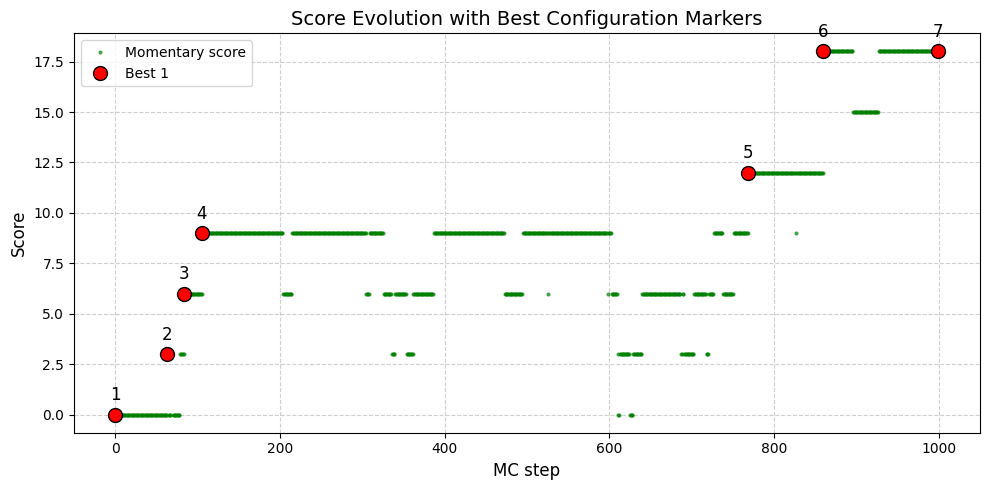